In [903]:
# Requisite imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import RidgeCV, RandomizedLasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
import eli5
from eli5.sklearn import PermutationImportance
from matplotlib.colors import LogNorm
import math

# The Datasets

The first dataset was obtained from NYC's Community Health Survey (CHS): https://www1.nyc.gov/site/doh/data/data-publications/profiles.page


> Metadata for this table can be found here: https://www.dropbox.com/s/8upe14gyxrtcja5/2015_CHP_PUD.xlsx?dl=0
Some headings are out of order in the metadata. 


The second dataset was taken from NYC's Environmental & Health Data Portal which aggregates data from many sources. For more info see: http://a816-dohbesp.nyc.gov/IndicatorPublic/BuildATable.aspx

In [2]:
raw_CHS_data = pd.read_csv('https://www.dropbox.com/s/thl1b27lxqvtpwo/2015_CHPdata.csv?raw=1',
                           index_col=0)

raw_EPHT_data = pd.read_csv('https://www.dropbox.com/s/gr9zh288m73dsvo/AllEPHTData.csv?raw=1',
                            index_col=False, header=None)

## Initial Processing

First, I take a look at how the dataframes are organized so I can eventually merge them.

In [3]:
print('Size of CHS Data: {}\nSize of EPHT Data:{}'.format(raw_CHS_data.shape,
                                                         raw_EPHT_data.shape))

Size of CHS Data: (65, 191)
Size of EPHT Data:(65500, 12)


In [4]:
original_CHS_columns = raw_CHS_data.columns.values.tolist()

print('Feature Names:\n', original_CHS_columns)

raw_CHS_data.head(8)

Feature Names:
 ['Name', 'OverallPopulation_rate', 'OverallPopulation_rank', 'Racewhite_Rate', 'Racewhite_rank', 'Raceblack_rate', 'Raceblack_rank', 'Raceasian_rate', 'Raceasian_rank', 'Racehispanic_rate', 'Racehispanic_rank', 'Raceother_rate', 'Raceother_rank', 'Nonwhite_rate', 'Nonwhite_rank', 'Age0to17_rate', 'Age0to17_rank', 'Age18to24_rate', 'Age18to24_rank', 'Age25to44_rate', 'Age25to44_rank', 'Age45to64_rate', 'Age45to64_rank', 'Age65plus_rate', 'Age65plus_rank', 'Foreign_born', 'Foreign_born_rank', 'lower_95CL', 'upper_95CL', 'Ltd_Eng_Prof', 'Ltd_eng_prof_rank', 'lower_95CL.1', 'upper_95CL.1', 'Housing_Defects', 'Housing_Defects_rank', 'lower_95CL.2', 'upper_95CL.2', 'Airquality_rate', 'Airquality_rank', 'Tobaccoretail_rate', 'Tobaccoretail_rank', 'Supermarketarea_rate', 'Supermarketarea_rank', 'Edudidnotcompletehs_rate', 'Edudidnotcompletehs_rank', 'Eduhsdegreeorsomecollege_rate', 'Eduhsdegreeorsomecollege_rank', 'Educollegedegreeandhigher_rate', 'Educollegedegreeandhigher_ran

,Name,OverallPopulation_rate,OverallPopulation_rank,Racewhite_Rate,Racewhite_rank,Raceblack_rate,Raceblack_rank,Raceasian_rate,Raceasian_rank,Racehispanic_rate,...,reliability note.15,Imr_rank,lower_95CL.31,upper_95CL.31,Premature_Mort,Premature_mort_rank,lower_95CL.32,upper_95CL.32,Life_expectancy_rate,Life_expectancy_rank
ID,,,,,,,,,,,,,,,,,,,,,
0,NYC,8405837,NaN,33,NaN,23,NaN,14,NaN,29,...,NaN,NaN,4.5,4.9,198.4,NaN,196.8,200.0,NaN,NaN
1,Manhattan,1626159,NaN,48,NaN,13,NaN,12,NaN,26,...,NaN,NaN,2.9,3.9,152.7,NaN,150.0,155.4,NaN,NaN
2,Bronx,1418733,NaN,11,NaN,30,NaN,4,NaN,55,...,NaN,NaN,5.1,6.3,238.9,NaN,235.2,242.6,NaN,NaN
3,Brooklyn,2592149,NaN,36,NaN,31,NaN,11,NaN,20,...,NaN,NaN,3.6,4.2,194.5,NaN,191.8,197.2,NaN,NaN
4,Queens,2296175,NaN,27,NaN,18,NaN,25,NaN,28,...,NaN,NaN,4.2,5.2,140.8,NaN,138.6,143.0,NaN,NaN
5,Staten Island,472621,NaN,63,NaN,10,NaN,8,NaN,18,...,NaN,NaN,3.6,5.8,184.7,NaN,179.3,190.1,NaN,NaN
101,Financial District,62829,57.0,66,9.0,4,44.0,20,13.0,8,...,*,58.0,0.2,2.8,75.6,59.0,64.3,86.9,85.4,1.0
102,Greenwich Village and Soho,91961,53.0,75,3.0,2,55.0,14,21.0,6,...,*,55.0,0.2,3.8,93.3,57.0,84.0,102.6,84.3,4.0


In [5]:
raw_EPHT_data.head(8)

,0,1,2,3,4,5,6,7,8,9,10,11
0,76966,462,Access to Alcohol,Number of Retail Outlets,Borough,1,Bronx,2009,1760,NaN,NaN,NaN
1,77014,464,Access to Alcohol,Number of Service Outlets,Borough,1,Bronx,2009,931,NaN,NaN,NaN
2,77062,463,Access to Alcohol,Retail Outlet Density,Borough,1,Bronx,2009,127,NaN,NaN,NaN
3,77110,465,Access to Alcohol,Service Outlet Density,Borough,1,Bronx,2009,67,NaN,NaN,NaN
4,76967,462,Access to Alcohol,Number of Retail Outlets,Borough,2,Brooklyn,2009,3206,NaN,NaN,NaN
5,77015,464,Access to Alcohol,Number of Service Outlets,Borough,2,Brooklyn,2009,2169,NaN,NaN,NaN
6,77063,463,Access to Alcohol,Retail Outlet Density,Borough,2,Brooklyn,2009,125,NaN,NaN,NaN
7,77111,465,Access to Alcohol,Service Outlet Density,Borough,2,Brooklyn,2009,85,NaN,NaN,NaN


In [245]:
raw_EPHT_data.iloc[:,4].value_counts()

UHF42       41242
UHF34       12478
Borough      6838
Citywide     1988
Subboro      1760
CD           1062
UHF33         132
Name: 4, dtype: int64

In [251]:
raw_EPHT_data[raw_EPHT_data.iloc[:,4]=='UHF42']

,0,1,2,3,4,5,6,7,8,9,10,11
24,76924,462,Access to Alcohol,Number of Retail Outlets,UHF42,101,Kingsbridge - Riverdale,2009,81,NaN,NaN,NaN
25,76972,464,Access to Alcohol,Number of Service Outlets,UHF42,101,Kingsbridge - Riverdale,2009,69,NaN,NaN,NaN
26,77020,463,Access to Alcohol,Retail Outlet Density,UHF42,101,Kingsbridge - Riverdale,2009,95,NaN,NaN,NaN
27,77068,465,Access to Alcohol,Service Outlet Density,UHF42,101,Kingsbridge - Riverdale,2009,81,NaN,NaN,NaN
28,76925,462,Access to Alcohol,Number of Retail Outlets,UHF42,102,Northeast Bronx,2009,166,NaN,NaN,NaN
29,76973,464,Access to Alcohol,Number of Service Outlets,UHF42,102,Northeast Bronx,2009,77,NaN,NaN,NaN
30,77021,463,Access to Alcohol,Retail Outlet Density,UHF42,102,Northeast Bronx,2009,88,NaN,NaN,NaN
31,77069,465,Access to Alcohol,Service Outlet Density,UHF42,102,Northeast Bronx,2009,41,NaN,NaN,NaN
32,76926,462,Access to Alcohol,Number of Retail Outlets,UHF42,103,Fordham - Bronx Pk,2009,308,NaN,NaN,NaN
33,76974,464,Access to Alcohol,Number of Service Outlets,UHF42,103,Fordham - Bronx Pk,2009,145,NaN,NaN,NaN


### Organization Insights

The first five rows in the CHS dataframe are borough summaries, but I am interested in Small Area Analysis. As a result I will omit these summaries. The remaining data of the Community Health Survey divides each borough into several Community Districts (CDs). 

Because the Environmental & Health Data Portal takes data from many sources, the aspects are organized in many different ways. As a result, each row represents a single statistic--with the columns enumerating the details regarding what was being measured and the corresponding location. This will be dealth with later.
For a first pass, I will take only those attributes organized by CD to ensure consistency when merging the datasets.

In [6]:
CD_EPHT_data = raw_EPHT_data[raw_EPHT_data.iloc[:,4]=='CD']

CD_CHS_data = raw_CHS_data.iloc[6:,:]

print('Environmental & Health Data:\n{}\n\n\nCommunity Health Survey Data:\n{}'.format(
    CD_EPHT_data.head(), CD_CHS_data.head()))

Environmental & Health Data:
           0    1                      2                3   4    5   \
50310  119438  373  Elemental Carbon (EC)  10th Percentile  CD  101   
50311  119497  374  Elemental Carbon (EC)  90th Percentile  CD  101   
50312  119379  370  Elemental Carbon (EC)             Mean  CD  101   
50313  119439  373  Elemental Carbon (EC)  10th Percentile  CD  102   
50314  119498  374  Elemental Carbon (EC)  90th Percentile  CD  102   

                      6         7                         8    9   10  11  
50310  Battery Park City   Tribeca  Annual Average 2009-2010  1.3 NaN NaN  
50311  Battery Park City   Tribeca  Annual Average 2009-2010  1.8 NaN NaN  
50312  Battery Park City   Tribeca  Annual Average 2009-2010  1.5 NaN NaN  
50313  Greenwich Village      SOHO  Annual Average 2009-2010  1.5 NaN NaN  
50314  Greenwich Village      SOHO  Annual Average 2009-2010    2 NaN NaN  


Community Health Survey Data:
                              Name  OverallPopulation_ra

### Inspecting NaN Values

In [7]:
# Because the CHS table has so many features, I will print out only those columns
# which contain NaNs. I will print out the result of all columns for the EPHT data.
CHS_NaN_columns = []

for column in original_CHS_columns:
    if CD_CHS_data.loc[:, column].isna().any():
        CHS_NaN_columns.append(column)

print('Columns in CHS data with NaN values:\n', CHS_NaN_columns)


print('\nColumns in Environment & Health data with any NaN values:\n',
      CD_EPHT_data.isna().any())

Columns in CHS data with NaN values:
 ['Avertabledeaths_rate', 'reliability note', 'reliability note.1', 'reliability note.2', 'reliability note.3', 'reliability note.4', 'reliability note.5', 'reliability note.6', 'reliability note.7', 'reliability note.8', 'reliability note.9', 'reliability note.10', 'reliability note.11', 'reliability note.12', 'reliability note.13', 'reliability note.14', 'reliability note.15']

Columns in Environment & Health data with any NaN values:
 0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9      True
10     True
11     True
dtype: bool


#### Dealing with NaNs in CHS Data

For ease of data analysis, reliability notes of CHS data will be discarded.

In [8]:
CHS_data_to_merge = CD_CHS_data.drop(columns=CHS_NaN_columns[1:])

print('Number of NaNs in Avertabledeaths_rate:', 
      CHS_data_to_merge.Avertabledeaths_rate.isna().sum())

Number of NaNs in Avertabledeaths_rate: 5


In [9]:
# In the CHS data, each rate is followed by a rank. I investigate here to see what
# those values are for the NaN Avertabledeaths_rate
CHS_data_to_merge[CHS_data_to_merge.Avertabledeaths_rate.isna()].Avertabledeaths_rank

ID
101    -
102    -
106    -
107    -
108    -
Name: Avertabledeaths_rank, dtype: object

In [22]:
CHS_data_to_merge.fillna(value=0, inplace=True)

#### Dealing with NaNs in the EPHT Data

I saw that the last three columns in the dataframe all contain NaNs. Upon further inspection of the source, any one of columns 8-11 of the EPHT dataset contains the actual relevant numerical data for any single row.

Columns 2 and 3 together describe the statistic measured, along with the column immediately preceding that with the actual numerical data.
Column 4 was used to describe the area level of analysis (e.g."Borough" or "CD" for Community District). In the dataset to merge, we only kept those with the label "CD", so this column is unnecessary.
Column 5 contains the CD index needed to match to the CHS data.
Following column 5, anywhere from 1 to 4 columns are used to enumerate the neighborhoods encompassed by the CD.

In [10]:
def get_values(row):
    '''
    This function determines the position of the numerical datum in a 
    specified row. It then assigns that value to the variable name `stat`.
    The position preceding the number is joined with positions 2 and 3 of 
    the row to create the `name` for the statistic.
    '''
    
    if str(row[8]).replace('.', '').isnumeric():
        stat = float(row[8])
        name = ' '.join([row[2], row[3], row[7]])
    
    elif str(row[9]).replace('.', '').isnumeric():
        stat = float(row[9])
        name = ' '.join([row[2], row[3], row[8]])
    
    elif str(row[10]).replace('.', '').isnumeric():
        stat = float(row[10])
        name = ' '.join([row[2], row[3], row[9]])
    
    else:
        stat = float(row[11])
        name = ' '.join([row[2], row[3], row[10]])

    return (name, stat)

In [11]:
CD_EPHT_data[['label', 'stat']] = CD_EPHT_data.apply(
    lambda row: pd.Series(get_values(row)), axis=1)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


### Using a Pivot Table to Transform the EPHT Data

In [12]:
EPHT_data_to_merge = CD_EPHT_data.pivot_table(index=5, columns='label', 
                                              values='stat')

### Merging the Tables

In [43]:
NYC_data = CHS_data_to_merge.merge(EPHT_data_to_merge, how='outer', 
                                   left_index=True, right_index=True)

In [44]:
to_standardize = NYC_data.drop(list(NYC_data.filter(regex='rank|CL|Percentile')),
                               axis=1)

print(to_standardize.shape)
to_standardize.head()

(59, 61)


,Name,OverallPopulation_rate,Racewhite_Rate,Raceblack_rate,Raceasian_rate,Racehispanic_rate,Raceother_rate,Nonwhite_rate,Age0to17_rate,Age18to24_rate,...,Avoidable_Diabetes,IMR,Premature_Mort,Life_expectancy_rate,Elemental Carbon (EC) Mean Annual Average 2009-2010,Elemental Carbon (EC) Mean Summer 2009,Elemental Carbon (EC) Mean Winter 2008-09,Fine Particulate Matter (PM2.5) Mean Annual Average 2009-2010,Fine Particulate Matter (PM2.5) Mean Summer 2009,Fine Particulate Matter (PM2.5) Mean Winter 2008-09
ID,,,,,,,,,,,,,,,,,,,,,
101,Financial District,62829,66,4,20,8,3,34,14,11,...,98,1.5,75.6,85.4,1.5,1.8,1.5,12.3,14.0,15.3
102,Greenwich Village and Soho,91961,75,2,14,6,3,25,9,10,...,54,2.0,93.3,84.3,1.8,1.8,1.6,12.9,13.6,16.8
103,Lower East Side and Chinatown,168298,31,7,34,25,2,69,13,12,...,275,2.4,183.0,80.9,1.6,1.5,1.6,12.1,12.6,16.0
104,Clinton and Chelsea,106128,60,6,14,18,2,40,9,8,...,156,4.9,140.5,82.0,1.7,1.8,1.8,12.9,13.7,16.5
105,Midtown,52607,68,4,18,8,2,32,7,12,...,72,4.5,145.4,82.9,1.9,2.0,2.0,15.7,15.4,19.2


In [45]:
to_standardize.isnull().sum()

Name                                                             0
OverallPopulation_rate                                           0
Racewhite_Rate                                                   0
Raceblack_rate                                                   0
Raceasian_rate                                                   0
Racehispanic_rate                                                0
Raceother_rate                                                   0
Nonwhite_rate                                                    0
Age0to17_rate                                                    0
Age18to24_rate                                                   0
Age25to44_rate                                                   0
Age45to64_rate                                                   0
Age65plus_rate                                                   0
Foreign_born                                                     0
Ltd_Eng_Prof                                                  

In [61]:
comm_districts = to_standardize[['Name']]
comm_districts

,Name
ID,
101,Financial District
102,Greenwich Village and Soho
103,Lower East Side and Chinatown
104,Clinton and Chelsea
105,Midtown
106,Stuyvesant Town and Turtle Bay
107,Upper West Side
108,Upper East Side
109,Morningside Heights and Hamilton Heights


In [390]:
def scale_df(df, scale_method='robust', feature_range=(0, 1)):
    if scale_method not in ['minmax', 'robust']:
        print('Warning: scale_method defaulting to StandardScaler() because no valid scaler detected.')
        scaler = StandardScaler()
    elif scale_method == 'robust':
        scaler = RobustScaler()
    elif scale_method == 'minmax':
        scaler = MinMaxScaler(feature_range=feature_range)
    else:
        scaler = StandardScaler()
    
    unstandardized = df.copy()
    
    data_s = scaler.fit_transform(unstandardized)

    new_df = pd.DataFrame(data=data_s, columns=unstandardized.columns, index=unstandardized.index)
    
    return new_df

In [349]:
edu_cols = ['Edudidnotcompletehs_rate', 'Eduhsdegreeorsomecollege_rate', 'Educollegedegreeandhigher_rate',
           'EduScore']

data_to_standardize = to_standardize.drop(columns=['Name'])

data_to_standardize['EduScore'] = data_to_standardize.apply(
    lambda row: row['Eduhsdegreeorsomecollege_rate'] + 2 * row['Educollegedegreeandhigher_rate'], axis=1)

X_to_standardize = data_to_standardize.drop(columns=edu_cols)

Y_to_standardize = data_to_standardize[edu_cols]

data_standardized = scale_df(data_to_standardize)

data_robust_scale = scale_df(data_to_standardize, scale_method='robust')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


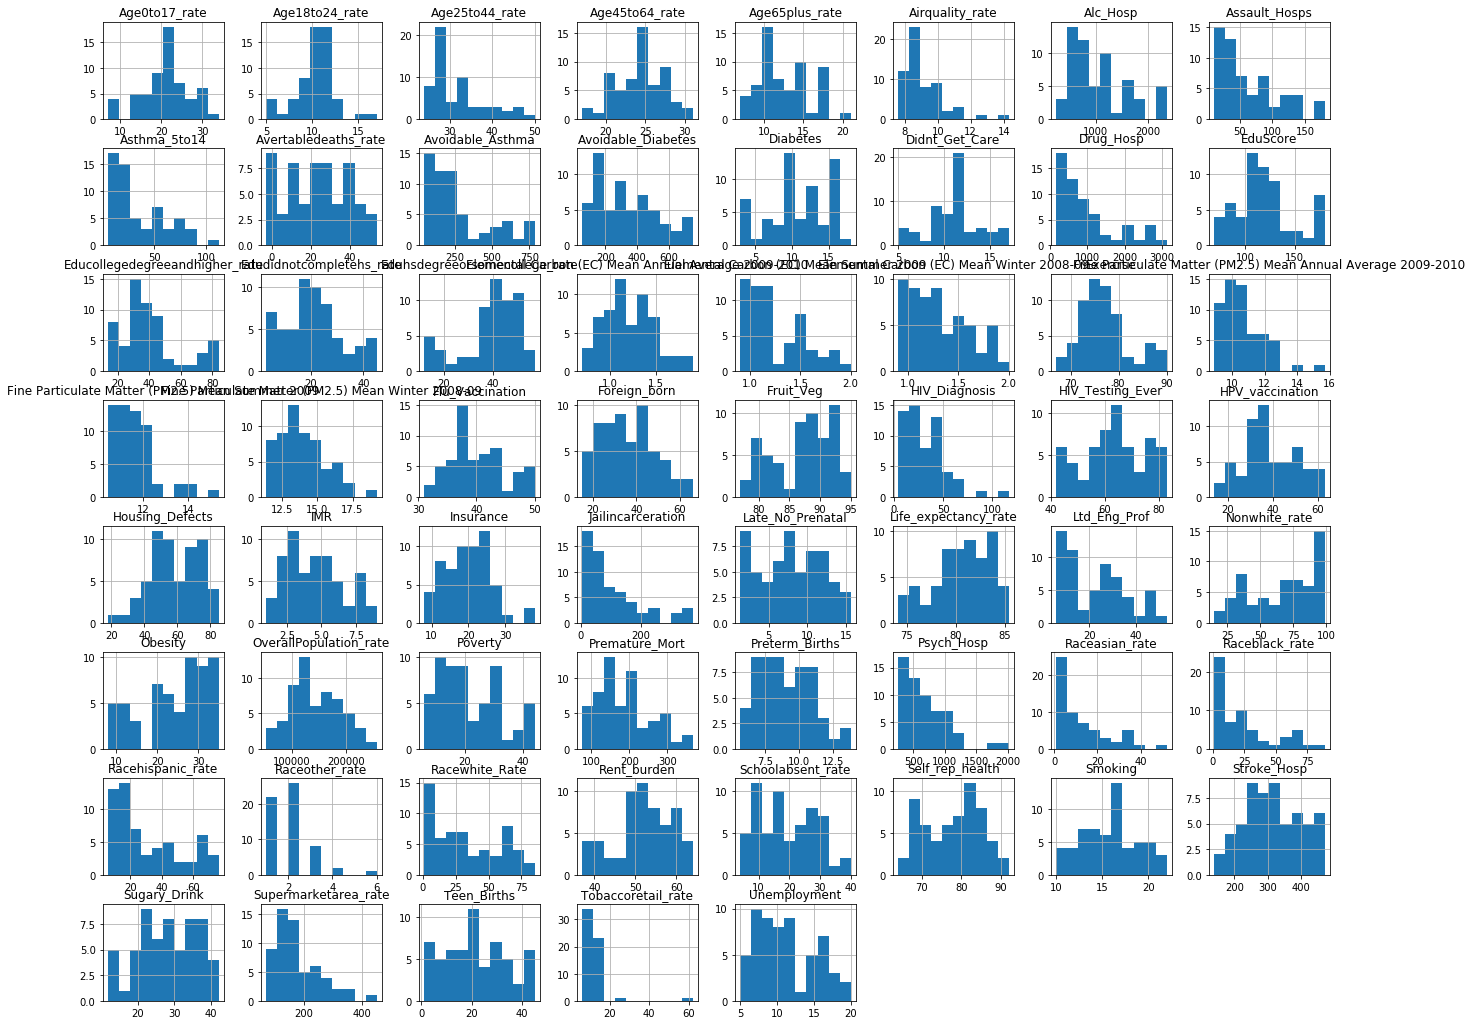

In [383]:
f, ax = plt.subplots(figsize=(22, 18))

data_to_standardize.hist(ax=ax);

plt.show()

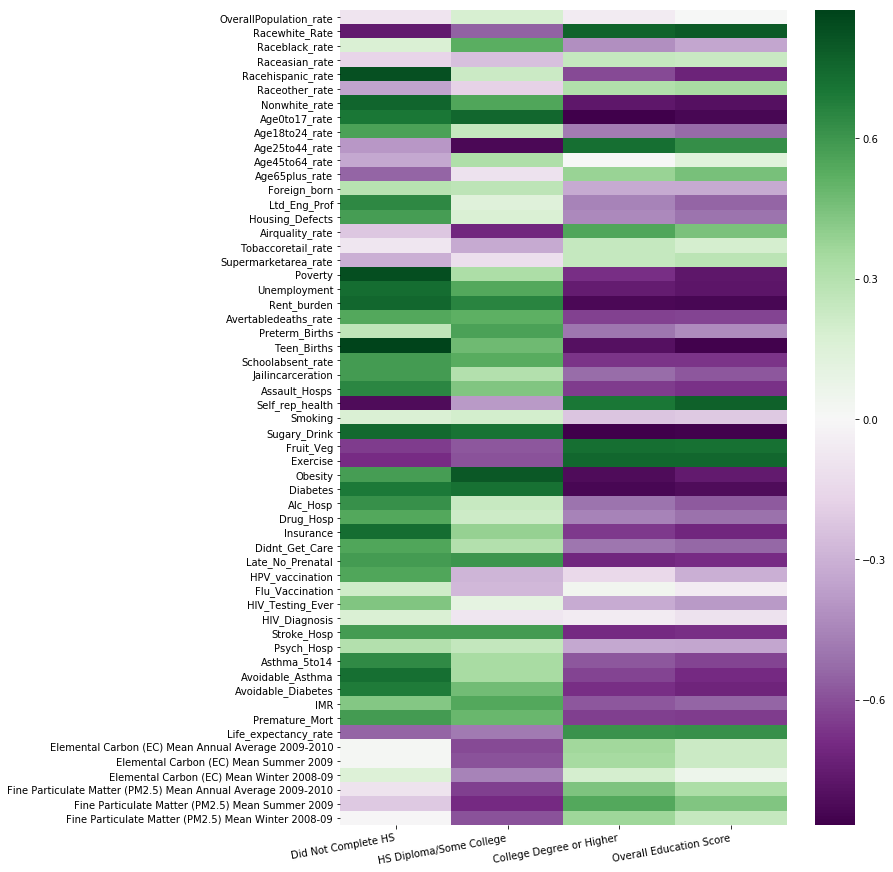

In [734]:
edu_labels = ['Did Not Complete HS', 'HS Diploma/Some College', 'College Degree or Higher',
             'Overall Education Score']

# Compute the correlation matrix
corr_standard = data_standardized.corr()[edu_cols]
corr_standard.drop(edu_cols, inplace=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_standard, cmap='PRGn').set_xticklabels(edu_labels, ha='right', rotation=10);

In [ ]:
Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, 
    BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, 
    Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, 
    Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, 
    Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, 
    Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, 
    YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, 
    autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, 
    coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, 
    gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, 
    gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, 
    gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, 
    magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, 
    plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, 
    summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, 
    viridis, viridis_r, vlag, vlag_r, winter, winter_r



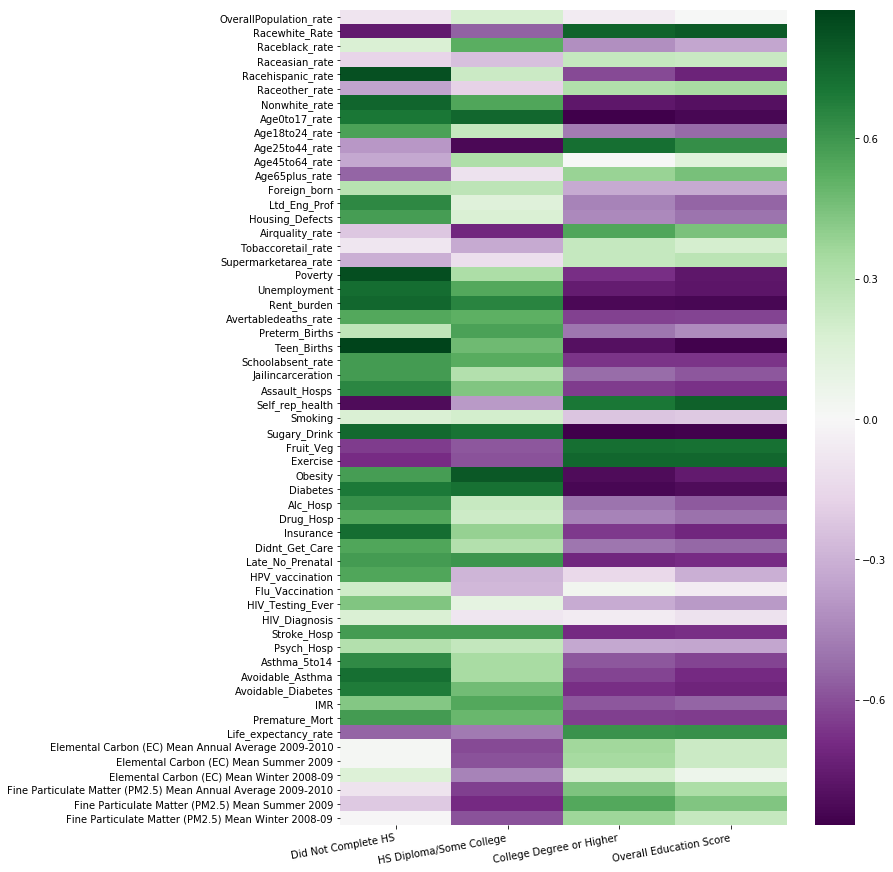

In [735]:
# Compute the correlation matrix
corr_robust = data_robust_scale.corr()[edu_cols]
corr_robust.drop(edu_cols, inplace=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_robust, cmap='PRGn').set_xticklabels(edu_labels, ha='right', rotation=10);

In [352]:
corr_robust.head()

,Edudidnotcompletehs_rate,Eduhsdegreeorsomecollege_rate,Educollegedegreeandhigher_rate,EduScore
OverallPopulation_rate,-0.092287,0.183809,-0.052996,0.004144
Racewhite_Rate,-0.758332,-0.550642,0.769933,0.795466
Raceblack_rate,0.172569,0.520188,-0.415392,-0.339106
Raceasian_rate,-0.164686,-0.245169,0.246923,0.227430
Racehispanic_rate,0.826898,0.225377,-0.613521,-0.720010


In [353]:
corr_standard.head()

,Edudidnotcompletehs_rate,Eduhsdegreeorsomecollege_rate,Educollegedegreeandhigher_rate,EduScore
OverallPopulation_rate,-0.092287,0.183809,-0.052996,0.004144
Racewhite_Rate,-0.758332,-0.550642,0.769933,0.795466
Raceblack_rate,0.172569,0.520188,-0.415392,-0.339106
Raceasian_rate,-0.164686,-0.245169,0.246923,0.227430
Racehispanic_rate,0.826898,0.225377,-0.613521,-0.720010


In [354]:
corr_standard.index

Index(['OverallPopulation_rate', 'Racewhite_Rate', 'Raceblack_rate',
       'Raceasian_rate', 'Racehispanic_rate', 'Raceother_rate',
       'Nonwhite_rate', 'Age0to17_rate', 'Age18to24_rate', 'Age25to44_rate',
       'Age45to64_rate', 'Age65plus_rate', 'Foreign_born', 'Ltd_Eng_Prof',
       'Housing_Defects', 'Airquality_rate', 'Tobaccoretail_rate',
       'Supermarketarea_rate', 'Poverty', 'Unemployment', 'Rent_burden',
       'Avertabledeaths_rate', 'Preterm_Births', 'Teen_Births',
       'Schoolabsent_rate', 'Jailincarceration', 'Assault_Hosps',
       'Self_rep_health', 'Smoking', 'Sugary_Drink', 'Fruit_Veg', 'Exercise',
       'Obesity', 'Diabetes', 'Alc_Hosp', 'Drug_Hosp', 'Insurance',
       'Didnt_Get_Care', 'Late_No_Prenatal', 'HPV_vaccination',
       'Flu_Vaccination', 'HIV_Testing_Ever', 'HIV_Diagnosis', 'Stroke_Hosp',
       'Psych_Hosp', 'Asthma_5to14', 'Avoidable_Asthma', 'Avoidable_Diabetes',
       'IMR', 'Premature_Mort', 'Life_expectancy_rate',
       'Elemental Carb

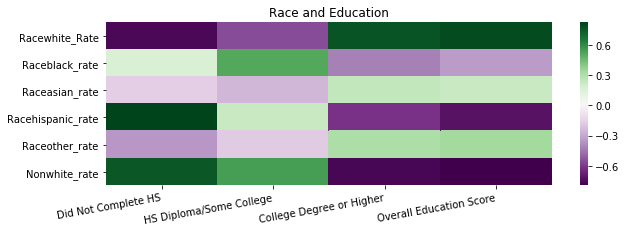

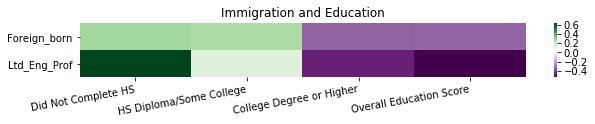

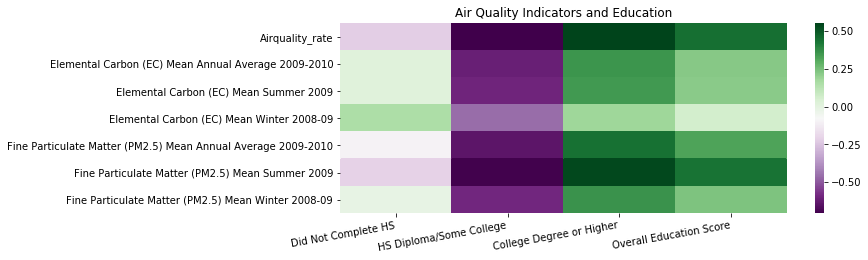

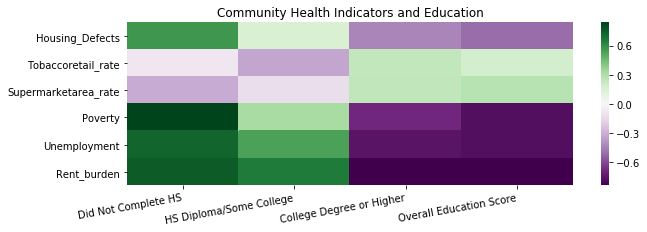

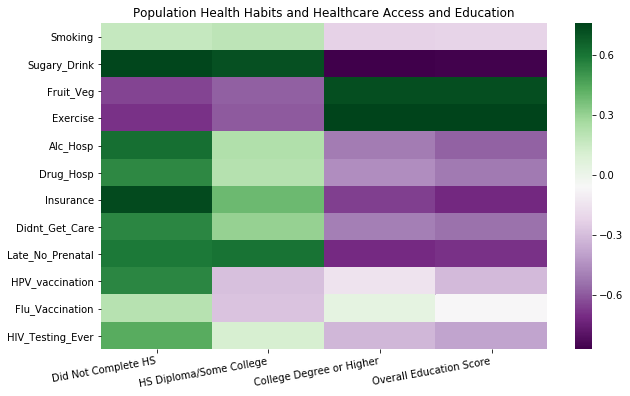

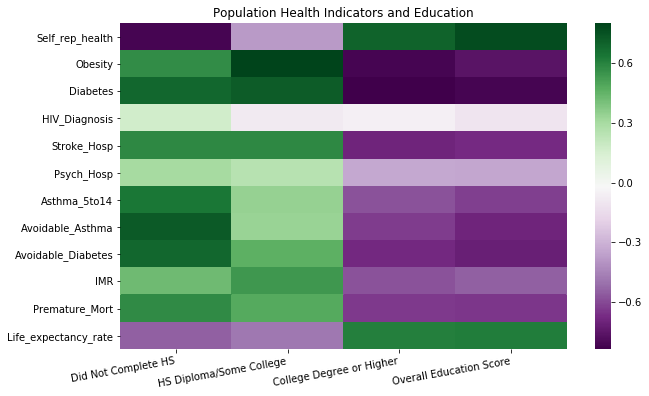

In [736]:
race = ['Racewhite_Rate', 'Raceblack_rate', 'Raceasian_rate', 'Racehispanic_rate',
        'Raceother_rate', 'Nonwhite_rate']
immigration = ['Foreign_born', 'Ltd_Eng_Prof']
air_quality = ['Airquality_rate', 'Elemental Carbon (EC) Mean Annual Average 2009-2010',
               'Elemental Carbon (EC) Mean Summer 2009', 'Elemental Carbon (EC) Mean Winter 2008-09',
               'Fine Particulate Matter (PM2.5) Mean Annual Average 2009-2010', 
               'Fine Particulate Matter (PM2.5) Mean Summer 2009',
               'Fine Particulate Matter (PM2.5) Mean Winter 2008-09']
neighborhood_wellness = ['Housing_Defects', 'Tobaccoretail_rate', 'Supermarketarea_rate',
                         'Poverty', 'Unemployment', 'Rent_burden']
health_habits_and_access = ['Smoking', 'Sugary_Drink', 'Fruit_Veg', 'Exercise', 'Alc_Hosp',
                            'Drug_Hosp', 'Insurance', 'Didnt_Get_Care', 'Late_No_Prenatal',
                            'HPV_vaccination', 'Flu_Vaccination', 'HIV_Testing_Ever']
health_indicators = ['Self_rep_health', 'Obesity', 'Diabetes', 'HIV_Diagnosis', 'Stroke_Hosp',
       'Psych_Hosp', 'Asthma_5to14', 'Avoidable_Asthma', 'Avoidable_Diabetes',
       'IMR', 'Premature_Mort', 'Life_expectancy_rate']

sections = {'Race and Education': race, 'Immigration and Education': immigration, 
            'Air Quality Indicators and Education': air_quality, 
            'Community Health Indicators and Education': neighborhood_wellness,
            'Population Health Habits and Healthcare Access and Education': health_habits_and_access,
            'Population Health Indicators and Education': health_indicators}


for label, section in sections.items():
    this_corr = corr_robust.loc[section]
    f, ax = plt.subplots(figsize=(10, len(this_corr)/2))
    plt.title(label)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(this_corr, cmap='PRGn').set_xticklabels(edu_labels, ha='right', rotation=10);
    plt.show();

In [900]:
def get_scores(X, Y, scale_method, scale_y=True, scale_importances=None):
    index_tuples = []
    model_data = []
    
    X = scale_df(X, scale_method)
    if scale_y:
        Y = scale_df(Y, scale_method)

    for level in Y.columns:
        ridge_model = RidgeCV()
        et_model = ExtraTreesRegressor(n_estimators=50, bootstrap=True)
        svr_model = SVR(C=.1)
        randL_model = RandomizedLasso()
    
        models = [ridge_model, et_model, svr_model]
    
        y = Y[level]

        for model in models:

            model.fit(X, y)
            score = model.score(X, y)
        
            model_name = f'{model}'.split('(')[0]
        
            try:
                coefs = model.coef_
            except:
                try:
                    importances = model.feature_importances_
                except:
                    importances = np.array(None)
            else:
                importances = np.absolute(coefs)
            finally:
                perm = PermutationImportance(model).fit(X, y)
                perm_importances = perm.feature_importances_
        
                index_tuple1 = (level, 'importances', score, model_name)
                index_tuple2 = (level, 'perm_importances', score, model_name)
        
                if importances.any():
                    index_tuples.append(index_tuple1)
                    model_data.append(importances)
                
                index_tuples.append(index_tuple2)
                model_data.append(perm_importances)

    data = np.array(model_data).T

    index = pd.MultiIndex.from_tuples(index_tuples, names=['Education Level', 'Measure', 'Score', 'Model'])

    df = pd.DataFrame(data, index=X.columns, columns=index)
    
    dfs = {}

    if scale_importances==None or scale_importances:
        df_scaled = scale_df(df, scale_method='minmax', feature_range=(0, 1))
    else:
        df_scaled = df.copy()
    
    for level in Y.columns:
        level_importances = df_scaled[level]['importances']
        level_perm_importances = df_scaled[level]['perm_importances']
    
        aggregated_importances = np.mean(level_importances.values, axis=1)
        aggregated_perm_importances = np.mean(level_perm_importances, axis=1)
    
        data = np.array([aggregated_importances, aggregated_perm_importances]).T
    
        dfs[level] = pd.DataFrame(data=data, index=X.columns,
                                  columns=['AggImportances', 'AggPermImportances'])
        
    return df, dfs, coefs

In [901]:
env_health_cols = ['Housing_Defects', 'Airquality_rate', 'Tobaccoretail_rate', 
                   'Supermarketarea_rate', 'Rent_burden', 'Avertabledeaths_rate',
                   'Preterm_Births', 'Assault_Hosps', 'Self_rep_health', 'Obesity',
                   'Diabetes', 'Alc_Hosp', 'Drug_Hosp', 'Insurance', 'Didnt_Get_Care',
                   'Late_No_Prenatal', 'HPV_vaccination', 'Flu_Vaccination',
                   'HIV_Testing_Ever', 'HIV_Diagnosis', 'Stroke_Hosp', 'Psych_Hosp', 
                   'Asthma_5to14', 'Avoidable_Asthma', 'Avoidable_Diabetes', 'IMR',
                   'Premature_Mort', 'Life_expectancy_rate',
                   'Elemental Carbon (EC) Mean Annual Average 2009-2010',
                   'Elemental Carbon (EC) Mean Summer 2009',
                   'Elemental Carbon (EC) Mean Winter 2008-09',
                   'Fine Particulate Matter (PM2.5) Mean Annual Average 2009-2010',
                   'Fine Particulate Matter (PM2.5) Mean Summer 2009',
                   'Fine Particulate Matter (PM2.5) Mean Winter 2008-09']

env_health_data = X_to_standardize[env_health_cols]

In [902]:
all_robust, all_robust_dfs, coefs_all_robust = get_scores(
    X_to_standardize, Y_to_standardize, 'robust', scale_y=True)
all_robust.head()

Education Level        Edudidnotcompletehs_rate                   \
Measure                             importances perm_importances   
Score                                  0.939117         0.939117   
Model                                   RidgeCV          RidgeCV   
OverallPopulation_rate                 0.004210         0.000019   
Racewhite_Rate                         0.064941         0.006413   
Raceblack_rate                         0.061634         0.012134   
Raceasian_rate                         0.060708         0.010216   
Racehispanic_rate                      0.124273         0.031653   

Education Level                                                           \
Measure                        importances    perm_importances             
Score                             0.973342            0.973342  0.560998   
Model                  ExtraTreesRegressor ExtraTreesRegressor       SVR   
OverallPopulation_rate            0.003812            0.001451  0.003056   
Racewhite_Rate                    0.067434            0.020193  0.007811   
Raceblack_rate                    0.004264            0.001446  0.010928   
Raceasian_rate                    0.001867            0.002782  0.007988   
Racehispanic_rate                 0.223363            0.118687  0.025504   

Education Level        Eduhsdegreeorsomecollege_rate                   \
Measure                                  importances perm_importances   
Score                                       0.924013         0.924013   
Model                                        RidgeCV          RidgeCV   
OverallPopulation_rate                      0.072150         0.008349   
Racewhite_Rate                              0.056218         0.003064   
Raceblack_rate                              0.060921         0.007521   
Raceasian_rate                              0.047303         0.005723   
Racehispanic_rate                           0.044691         0.002231   

Education Level                                                           \
Measure                        importances    perm_importances             
Score                             0.978270            0.978270  0.425107   
Model                  ExtraTreesRegressor ExtraTreesRegressor       SVR   
OverallPopulation_rate            0.003293            0.001872  0.002250   
Racewhite_Rate                    0.004018            0.001766  0.006417   
Raceblack_rate                    0.006469            0.001968  0.012996   
Raceasian_rate                    0.005487            0.002005  0.005505   
Racehispanic_rate                 0.005739            0.001130  0.004276   

Education Level        Educollegedegreeandhigher_rate                   \
Measure                                   importances perm_importances   
Score                                        0.953359         0.953359   
Model                                         RidgeCV          RidgeCV   
OverallPopulation_rate                       0.047582         0.003920   
Racewhite_Rate                               0.085987         0.006437   
Raceblack_rate                               0.008428         0.000145   
Raceasian_rate                               0.016855         0.000783   
Racehispanic_rate                            0.124068         0.014743   

Education Level                                                           \
Measure                        importances    perm_importances             
Score                             0.982389            0.982389  0.432196   
Model                  ExtraTreesRegressor ExtraTreesRegressor       SVR   
OverallPopulation_rate            0.001628            0.001219  0.000554   
Racewhite_Rate                    0.027319            0.006473  0.008959   
Raceblack_rate                    0.000227            0.000400  0.005861   
Raceasian_rate                    0.004390            0.000984  0.004127   
Racehispanic_rate                 0.005130            0.003366  0.009241   

Educati

In [888]:
env_health_robust, env_health_robust_dfs, coefs_env_health_robust = get_scores(
    env_health_data, Y_to_standardize, 'robust', scale_y=True)
env_health_robust.head()

Education Level      Edudidnotcompletehs_rate                   \
Measure                           importances perm_importances   
Score                                0.889833         0.889833   
Model                                 RidgeCV          RidgeCV   
Housing_Defects                      0.017240         0.000224   
Airquality_rate                      0.078481         0.023707   
Tobaccoretail_rate                   0.016016         0.001366   
Supermarketarea_rate                 0.062515         0.006421   
Rent_burden                          0.181184         0.122273   

Education Level                                                         \
Measure                      importances    perm_importances             
Score                           0.970230            0.970230  0.911839   
Model                ExtraTreesRegressor ExtraTreesRegressor       SVR   
Housing_Defects                 0.009366            0.003036  0.006142   
Airquality_rate                 0.012390            0.004209  0.017562   
Tobaccoretail_rate              0.003275            0.001717  0.054698   
Supermarketarea_rate            0.001993            0.000041  0.015979   
Rent_burden                     0.053687            0.027394  0.103393   

Education Level      Eduhsdegreeorsomecollege_rate                   \
Measure                                importances perm_importances   
Score                                     0.859374         0.859374   
Model                                      RidgeCV          RidgeCV   
Housing_Defects                           0.086438         0.008489   
Airquality_rate                           0.112142         0.018781   
Tobaccoretail_rate                        0.058783         0.027032   
Supermarketarea_rate                      0.038123         0.003425   
Rent_burden                               0.258783         0.159858   

Education Level                                                         \
Measure                      importances    perm_importances             
Score                           0.962717            0.962717  0.878479   
Model                ExtraTreesRegressor ExtraTreesRegressor       SVR   
Housing_Defects                 0.008816            0.004627  0.009814   
Airquality_rate                 0.074543            0.054592  0.040551   
Tobaccoretail_rate              0.001306            0.000681  0.023367   
Supermarketarea_rate            0.007133            0.004729  0.004361   
Rent_burden                     0.106415            0.053483  0.107823   

Education Level      Educollegedegreeandhigher_rate                   \
Measure                                 importances perm_importances   
Score                                      0.902231         0.902231   
Model                                       RidgeCV          RidgeCV   
Housing_Defects                            0.070001         0.009266   
Airquality_rate                            0.135297         0.031862   
Tobaccoretail_rate                         0.051148         0.017679   
Supermarketarea_rate                       0.023494        -0.000268   
Rent_burden                                0.303927         0.185644   

Education Level                                                         \
Measure                      importances    perm_importances             
Score                           0.978733            0.978733  0.924506   
Model                ExtraTreesRegressor ExtraTreesRegressor       SVR   
Housing_Defects                 0.005506            0.005136  0.003845   
Airquality_rate                 0.003339            0.001233  0.028593   
Tobaccoretail_rate              0.002472            0.001583  0.012604   
Supermarketarea_rate            0.013148            0.002676  0.005435   
Rent_burden                     0.142124            0.168769  0.118720   

Education Level         EduScore                                       \
Measure              importances perm_impo

In [889]:
def get_total(dfs):
    averages = []
    for level, df in dfs.items():
        average = df.mean(axis=1)
        averages.append(average)

    together = pd.concat(averages, axis=1)
    
    together.columns = dfs.keys()
    
    together['Extremes'] = together.apply(lambda row: (row['Edudidnotcompletehs_rate'] +
                                         row['Educollegedegreeandhigher_rate']) / 2, axis=1)
    
    return together

In [890]:
env_health_robust_total = get_total(env_health_robust_dfs)

env_health_robust_total.head(10)

,Edudidnotcompletehs_rate,Eduhsdegreeorsomecollege_rate,Educollegedegreeandhigher_rate,EduScore,Extremes
Housing_Defects,0.030880,0.108244,0.076894,0.054134,0.053887
Airquality_rate,0.156420,0.274043,0.180215,0.215937,0.168317
Tobaccoretail_rate,0.104296,0.114026,0.074321,0.087382,0.089308
Supermarketarea_rate,0.096684,0.045623,0.039406,0.049282,0.068045
Rent_burden,0.617878,0.698441,0.925250,1.000000,0.771564
Avertabledeaths_rate,0.069778,0.101687,0.091389,0.092519,0.080583
Preterm_Births,0.086798,0.148201,0.021471,0.024222,0.054134
Assault_Hosps,0.102480,0.076629,0.121992,0.119533,0.112236
Self_rep_health,0.783160,0.148128,0.173368,0.335781,0.478264
Obesity,0.074456,0.771787,0.417598,0.191389,0.246027


In [891]:
all_robust_total = get_total(all_robust_dfs)
all_robust_total.head(10)

,Edudidnotcompletehs_rate,Eduhsdegreeorsomecollege_rate,Educollegedegreeandhigher_rate,EduScore,Extremes
OverallPopulation_rate,0.055779,0.150558,0.134311,0.085075,0.095045
Racewhite_Rate,0.204745,0.104921,0.317597,0.490296,0.261171
Raceblack_rate,0.276932,0.196297,0.032942,0.097415,0.154937
Raceasian_rate,0.272184,0.115258,0.049098,0.112366,0.160641
Racehispanic_rate,0.863429,0.103485,0.406827,0.558199,0.635128
Raceother_rate,0.176960,0.171411,0.255760,0.275304,0.216360
Nonwhite_rate,0.286842,0.129911,0.271796,0.282535,0.279319
Age0to17_rate,0.185164,0.913801,0.611479,0.542293,0.398322
Age18to24_rate,0.233399,0.198266,0.353076,0.419557,0.293238
Age25to44_rate,0.038143,0.808902,0.453619,0.419297,0.245881


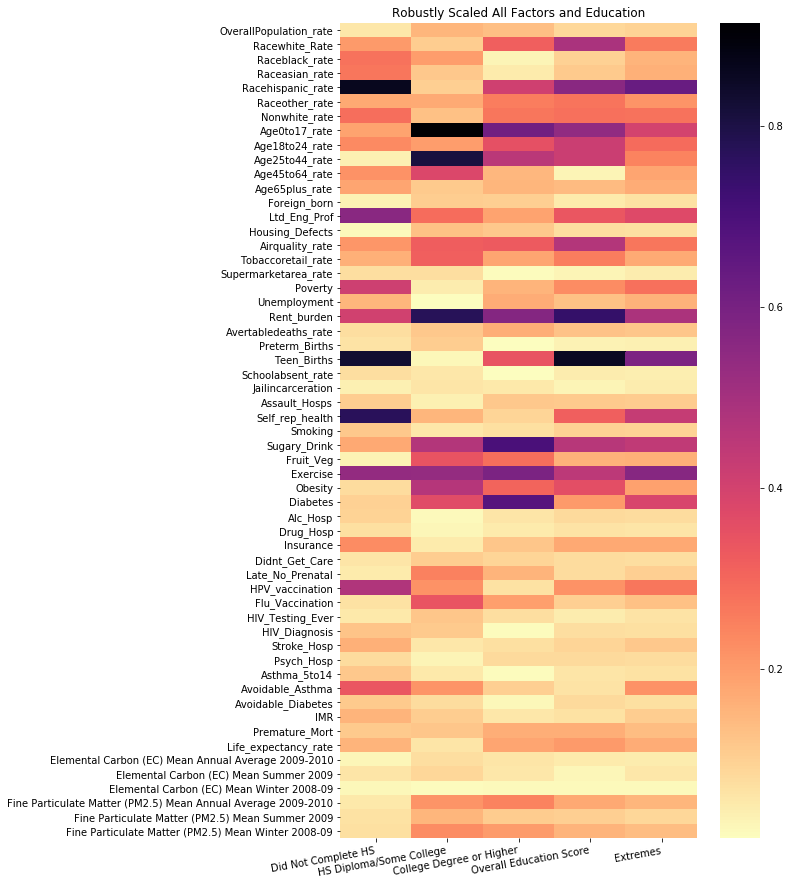

In [892]:
labels = ['Did Not Complete HS', 'HS Diploma/Some College', 'College Degree or Higher',
             'Overall Education Score', 'Extremes']

f, ax = plt.subplots(figsize=(8, 15))
plt.title('Robustly Scaled All Factors and Education')
sns.heatmap(all_robust_total, cmap='magma_r').set_xticklabels(labels, ha='right', rotation=10);
plt.show();

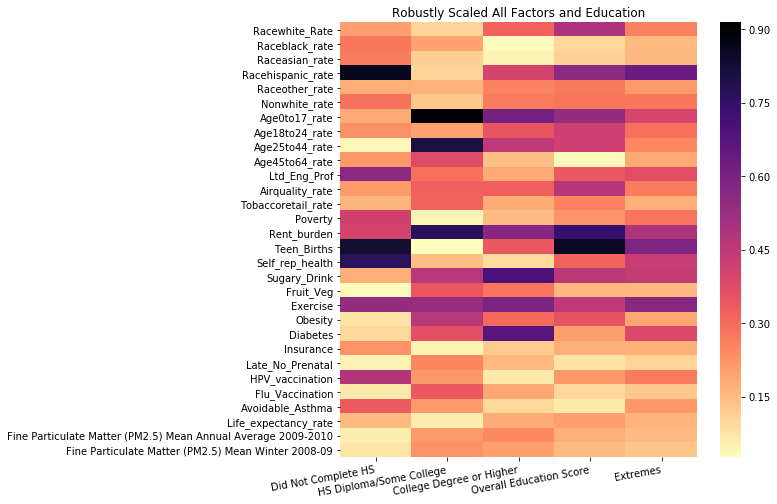

In [893]:
all_robust_filtered = all_robust_total[all_robust_total.max(axis=1) >= 0.2]

f, ax = plt.subplots(figsize=(8, 8))
plt.title('Robustly Scaled All Factors and Education')
sns.heatmap(all_robust_filtered, cmap='magma_r').set_xticklabels(labels, ha='right', rotation=10);
plt.show();

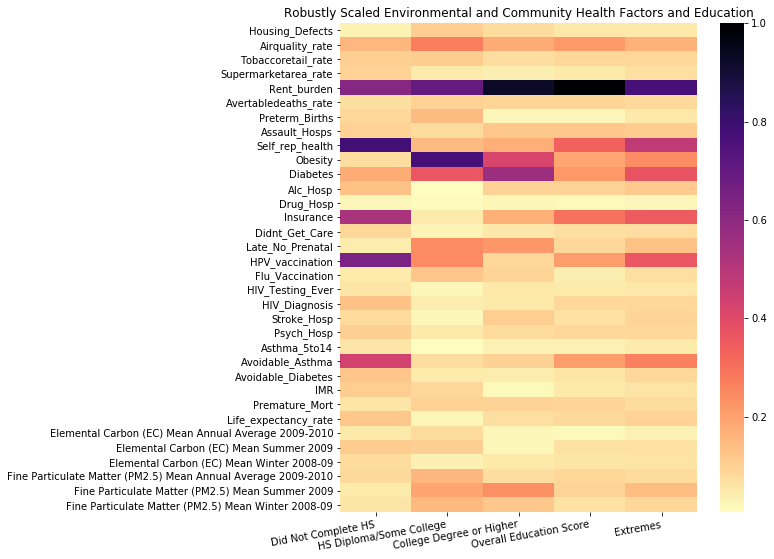

In [894]:
f, ax = plt.subplots(figsize=(8, 9))
plt.title('Robustly Scaled Environmental and Community Health Factors and Education')
sns.heatmap(env_health_robust_total, cmap='magma_r').set_xticklabels(labels, ha='right', rotation=10);
plt.show();

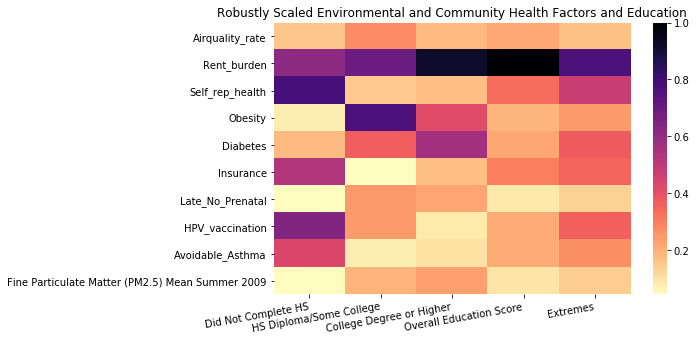

In [895]:
env_health_robust_filtered = env_health_robust_total[env_health_robust_total.max(axis=1) >= 0.2]

f, ax = plt.subplots(figsize=(8, 5))
plt.title('Robustly Scaled Environmental and Community Health Factors and Education')
sns.heatmap(env_health_robust_filtered, cmap='magma_r').set_xticklabels(labels, ha='right', rotation=10);
plt.show();

In [896]:
def zero_floor(value):
    if value < 1e-4:
        value = 1e-4
    return value

#for col in env_health_robust.columns:
#    env_health_robust[col] = env_health_robust[col].apply(zero_floor)
    
#for col in all_robust.columns:
#    all_robust[col] = all_robust[col].apply(zero_floor)

In [897]:
def make_heatmaps(df, figsize=(8, 8)):
    df.columns = df.columns.reorder_levels(['Model', 'Measure', 'Score', 'Education Level'])
    for model in ['ExtraTreesRegressor', 'RandomForestRegressor', 'RidgeCV', 'SVR']:
        for measure in ['importances', 'perm_importances']:
            try:
                df_ = scale_df(df[model][measure], scale_method='minmax')
            except:
                pass
            else:
                for idx in df_.columns.remove_unused_levels().values:
                    score = idx[0]
                    df_[idx] = df_[idx].apply(lambda x: x*score)
                
                df_.columns = edu_cols
                
                f, ax = plt.subplots(figsize=figsize)
                plt.title(f'{model} {measure}') 
                sns.heatmap(df_, cmap='magma_r').set_xticklabels(edu_labels, ha='right', rotation=10);

                plt.show();
                
                df_filtered = df_[df_.max(axis=1) >= 0.2]
                
                f, ax = plt.subplots(figsize=(figsize[0], len(df_filtered.index)/5))
                plt.title(f'{model} {measure} filtered') 
                sns.heatmap(df_filtered, cmap='magma_r').set_xticklabels(edu_labels, ha='right', rotation=10);

                plt.show();

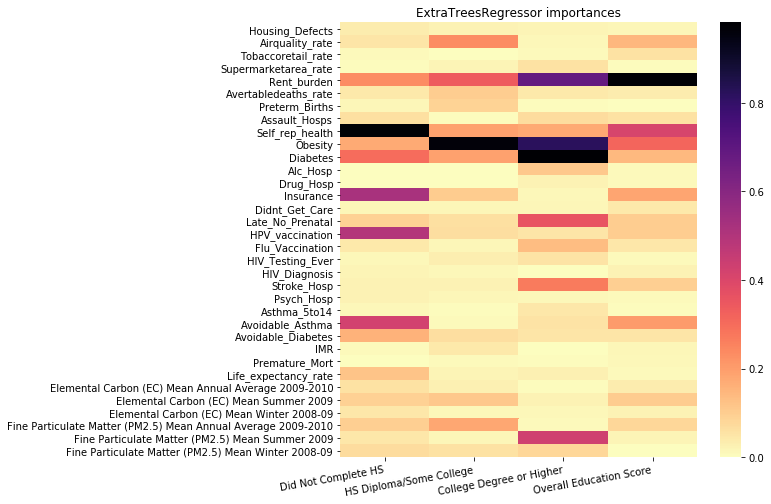

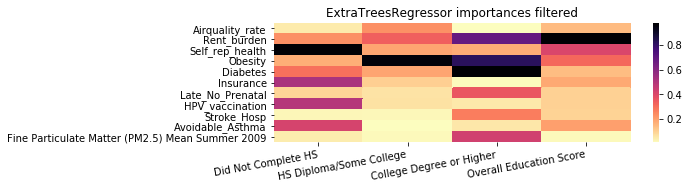

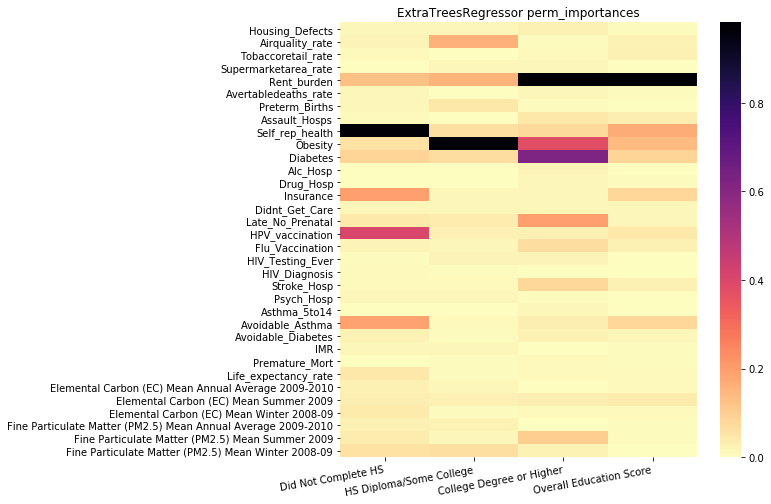

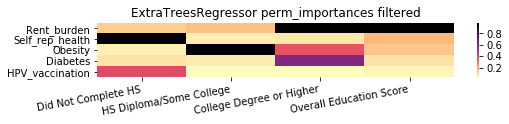

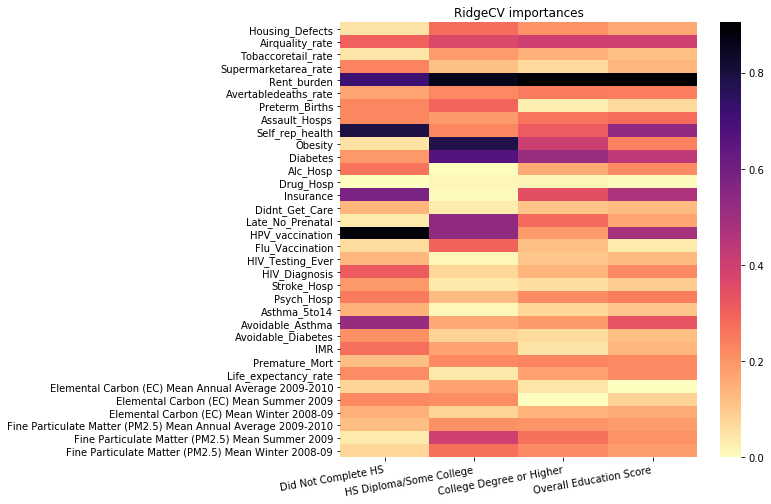

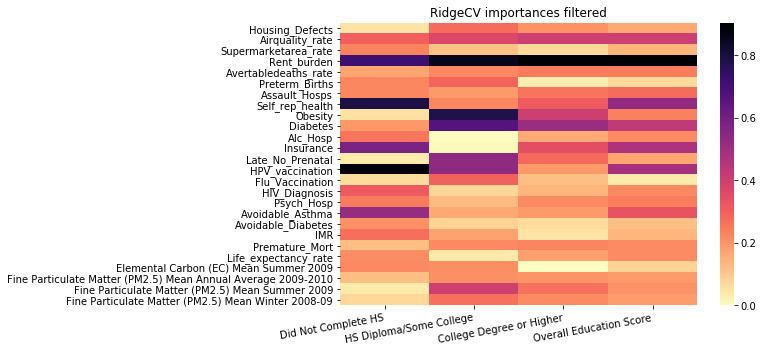

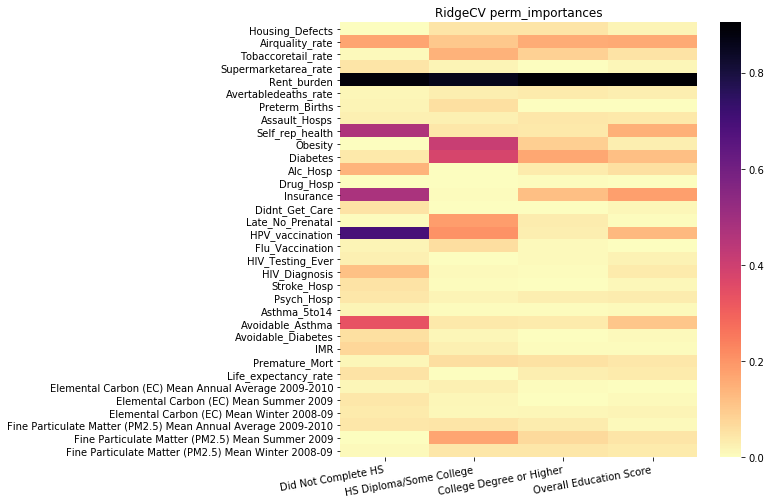

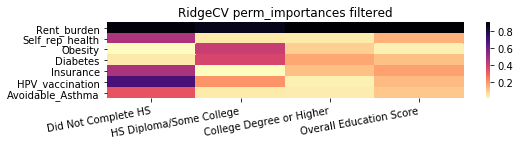

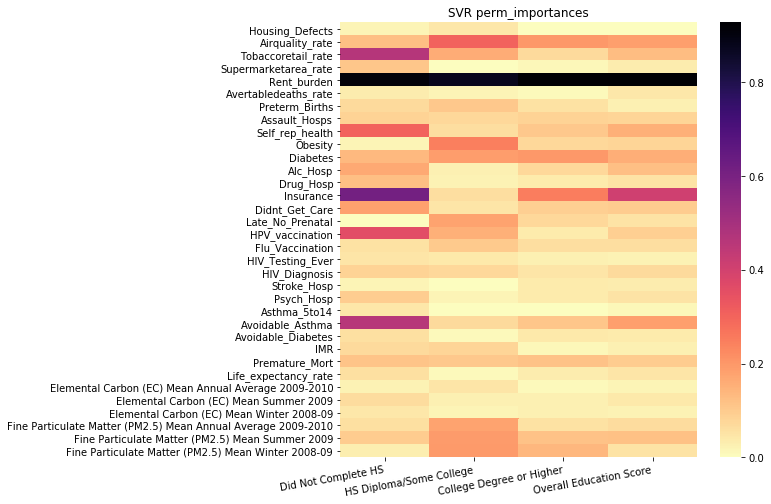

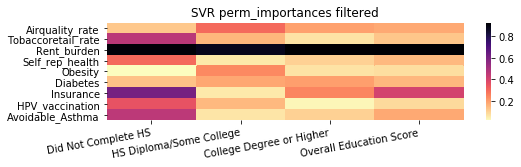

In [898]:
make_heatmaps(env_health_robust)

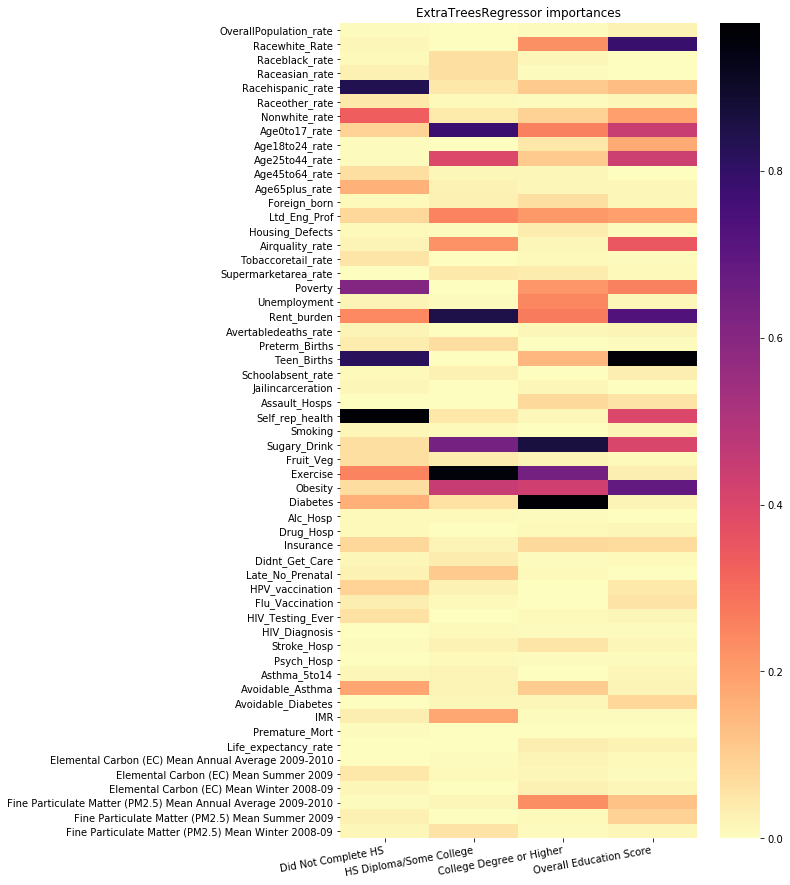

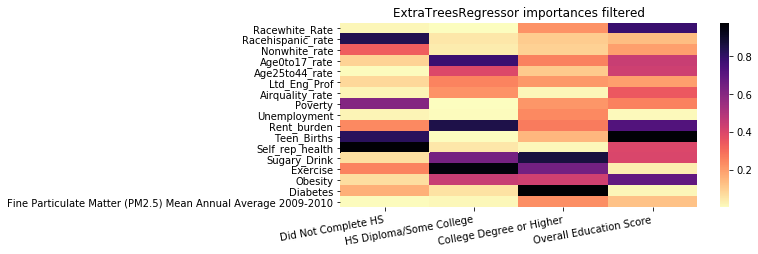

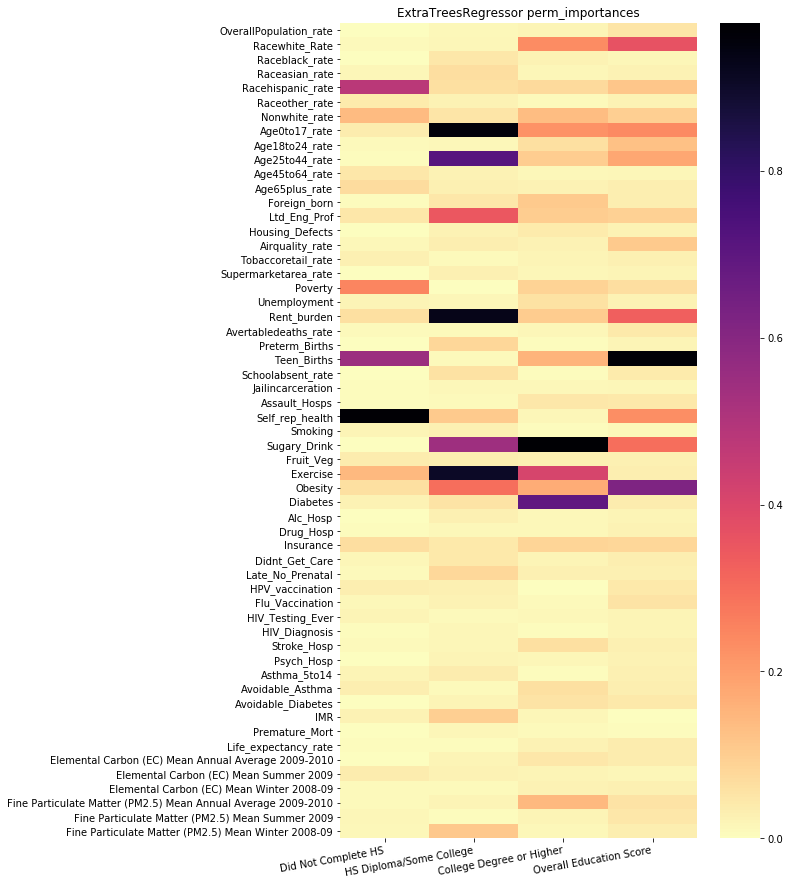

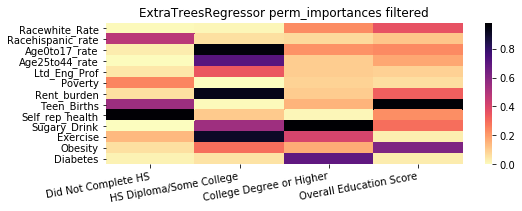

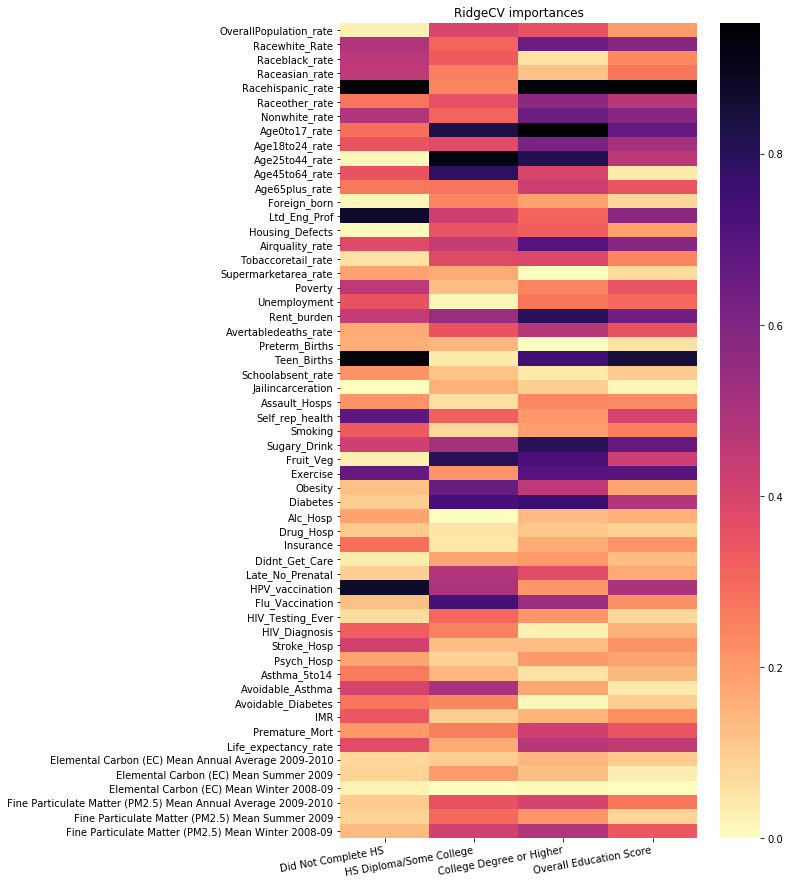

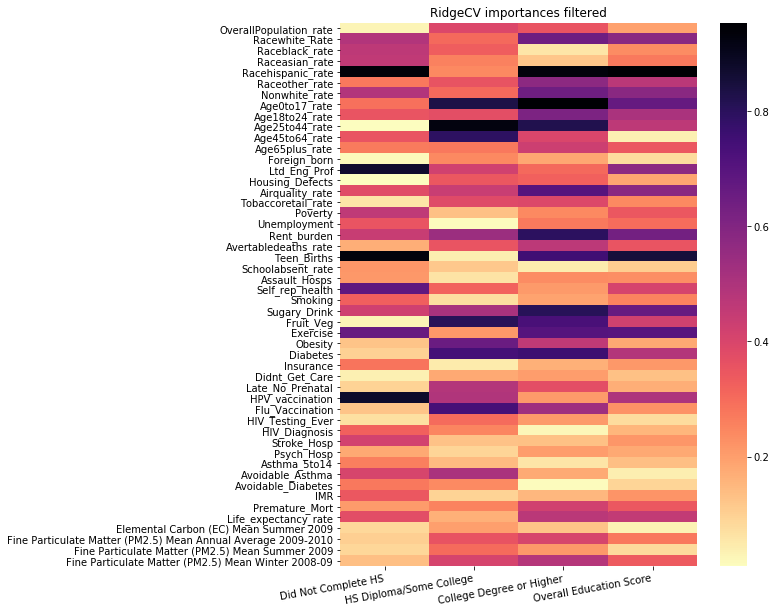

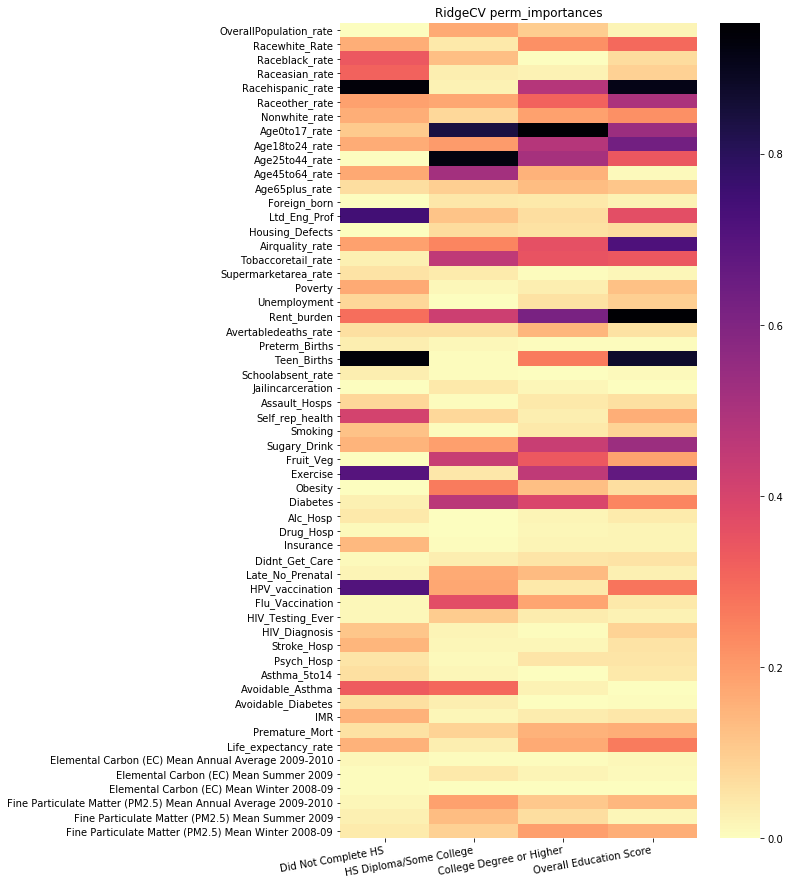

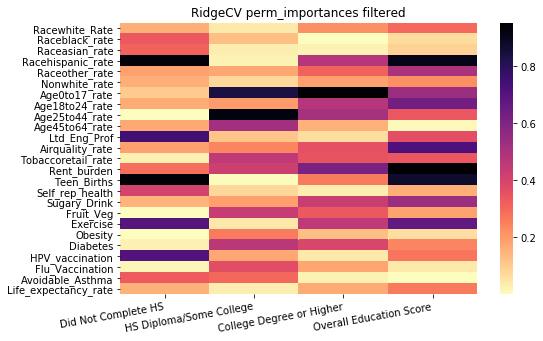

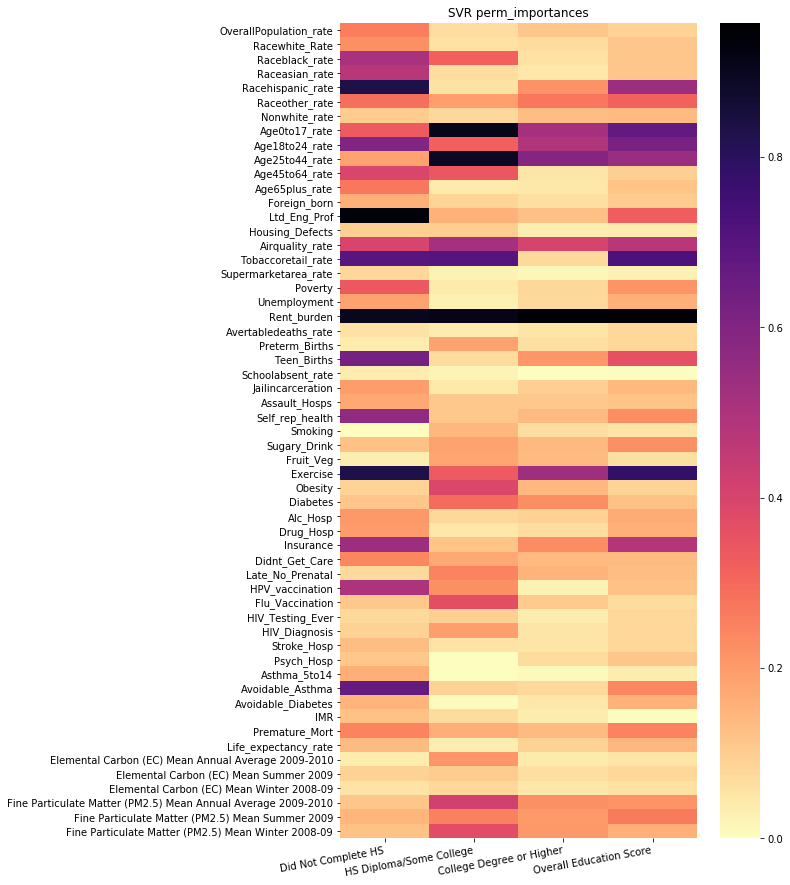

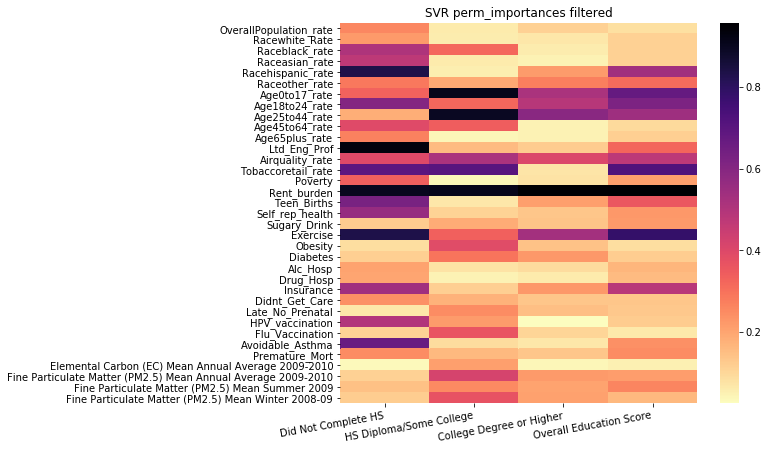

In [899]:
make_heatmaps(all_robust, figsize=(8, 15))

In [871]:
import sklearn.feature_selection as fs

MIR_scores = []

for col in Y_to_standardize.columns:
    MIR = fs.SelectKBest(fs.mutual_info_regression, k='all').fit(X_to_standardize, Y_to_standardize[col])
    MIR_series = pd.Series(data=MIR.scores_, name=f'MI_Reg_Scores for {col}', index=X_to_standardize.columns)
    MIR_scores.append(MIR_series)

mutual_info_scores = pd.concat(MIR_scores, axis=1)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


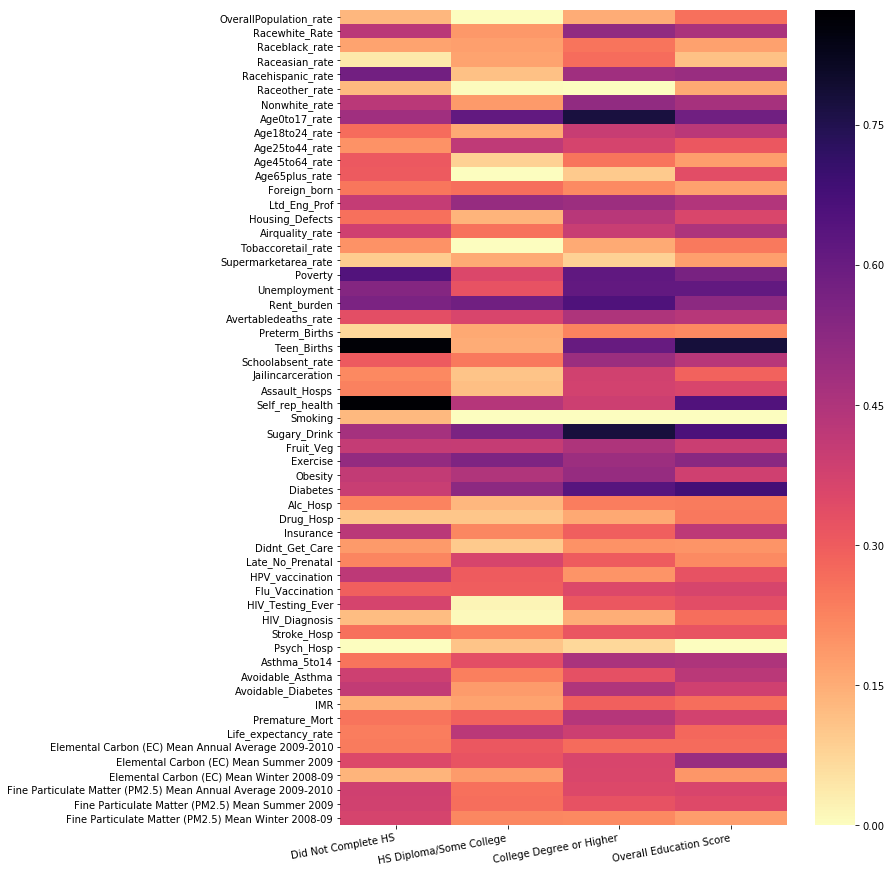

In [839]:
f, ax = plt.subplots(figsize=(10, 15))

sns.heatmap(mutual_info_scores, cmap='magma_r').set_xticklabels(edu_labels, ha='right', rotation=10);

plt.show();

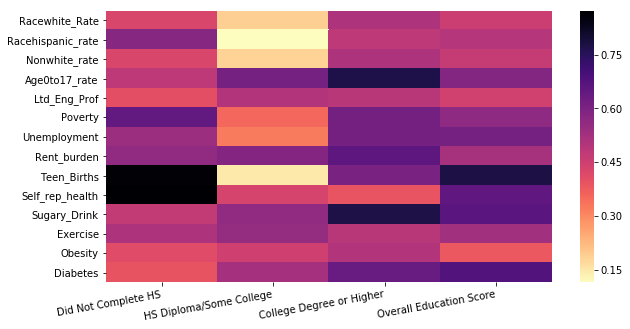

In [840]:
mutual_info_filtered = mutual_info_scores[mutual_info_scores.max(axis=1) >= 0.5]

f, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(mutual_info_filtered, cmap='magma_r').set_xticklabels(edu_labels, ha='right', rotation=10);

plt.show();

In [841]:
env_health_data

MIR_env_health_scores = []

for col in Y_to_standardize.columns:
    MIR = fs.SelectKBest(fs.mutual_info_regression, k='all').fit(env_health_data, Y_to_standardize[col])
    MIR_series = pd.Series(data=MIR.scores_, name=f'MI_Reg_Scores for {col}', index=env_health_data.columns)
    MIR_env_health_scores.append(MIR_series)

MI_env_health_scores = pd.concat(MIR_env_health_scores, axis=1)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


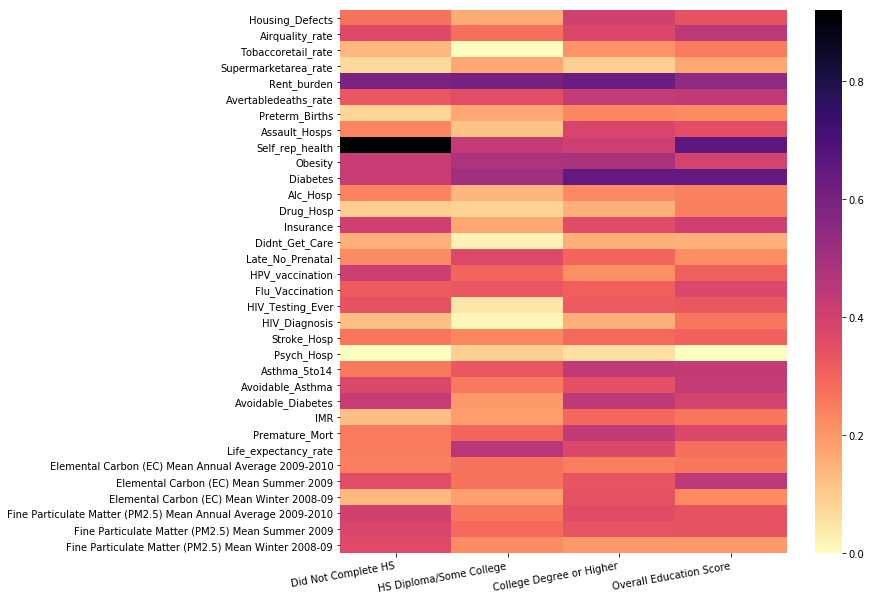

In [842]:
f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(MI_env_health_scores, cmap='magma_r').set_xticklabels(edu_labels, ha='right', rotation=10);

plt.show();